# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Colorado/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Colorado/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)

C:\Users\rjame\AppData\Local\Temp\ipykernel_16788\447271929.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)


In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Groundwater']
13


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,COre_RUco1,4326,Central Yuma,co1,NaN,Ground Water Management District,9/1/1996,CO,POLYGON ((-102.05165785046351 40.1771465166028...,COre_ROco1,Groundwater


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Surface Water' 'Groundwater' 'WaDE Blank']
125927


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,COwr_S100500,NaN,COwr_WSwadeID2,WaDE Blank,Digitized,Weld,4326,NaN,NaN,NaN,NaN,40.40259,-104.53019,NaN,NaN,POD,Hoover Ditch,100500,NaN,Ditch,CO,NaN,COwr_WSwadeID2,Surface Water


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Ground Water Management District" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

13
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,COre_RUco1,4326,Central Yuma,co1,NaN,Ground Water Management District,9/1/1996,CO,POLYGON ((-102.05165785046351 40.1771465166028...,COre_ROco1,Groundwater


<GeoAxesSubplot: >

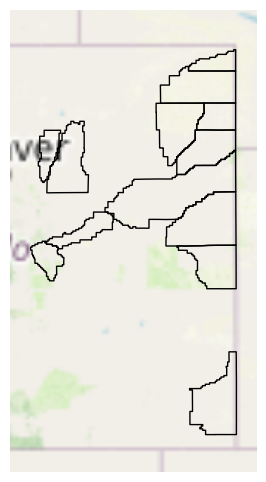

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
nameOfWaterSourceTypeCV= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[dfs1['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

63063
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
144,COwr_S100786,NaN,COwr_WSwadeID4,WaDE Blank,Spotted from section lines,Weld,4326,NaN,NaN,NaN,NaN,40.49023,-104.63988,NaN,NaN,POD,Bickling Pl Sump,100786,NaN,Well,CO,NaN,COwr_WSwadeID4,Groundwater


<GeoAxesSubplot: >

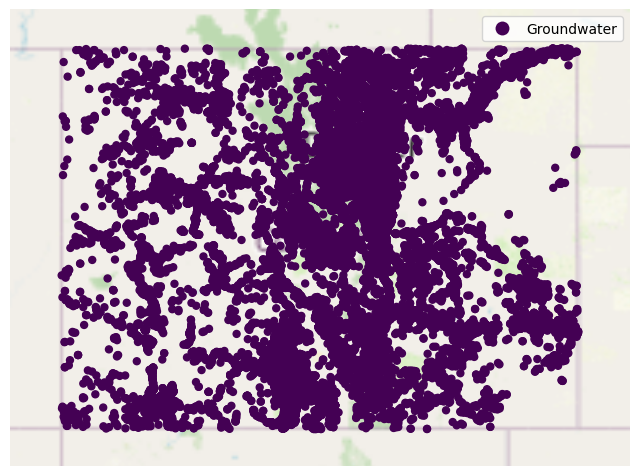

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

306


C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
1512,COwr_S105045,,COwr_WSwadeID34,WaDE Blank,Spotted from section lines,Adams,4326,,,,,39.88500,-104.51019,,,POD,Anderson Well 6528,105045,,Well,CO,,COwr_WSwadeID34,Groundwater,POINT (-104.51019 39.88500),2,COre_RUco11,COre_ROco11
1923,COwr_S105499,,COwr_WSwadeID4,WaDE Blank,Spotted from section lines,Adams,4326,,,,,39.88423,-104.53767,,,POD,Anderson Well 2,105499,,Well,CO,,COwr_WSwadeID4,Groundwater,POINT (-104.53767 39.88423),2,COre_RUco11,COre_ROco11
2040,COwr_S105628,,COwr_WSwadeID34,WaDE Blank,Spotted from section lines,Weld,4326,,,,,40.08658,-104.41408,,,POD,Baumgartner Well 0510,105628,,Well,CO,,COwr_WSwadeID34,Groundwater,POINT (-104.41408 40.08658),2,COre_RUco11,COre_ROco11
2042,COwr_S105630,,COwr_WSwadeID34,WaDE Blank,Spotted from section lines,Weld,4326,,,,,40.06961,-104.43515,,,POD,Baumgartner Well 1827,105630,,Well,CO,,COwr_WSwadeID34,Groundwater,POINT (-104.43515 40.06961),2,COre_RUco11,COre_ROco11
2043,COwr_S105631,,COwr_WSwadeID34,WaDE Blank,Spotted from section lines,Weld,4326,,,,,40.03681,-104.41876,,,POD,Baumgartner Well 4477,105631,,Well,CO,,COwr_WSwadeID34,Groundwater,POINT (-104.41876 40.03681),2,COre_RUco11,COre_ROco11


<GeoAxesSubplot: >

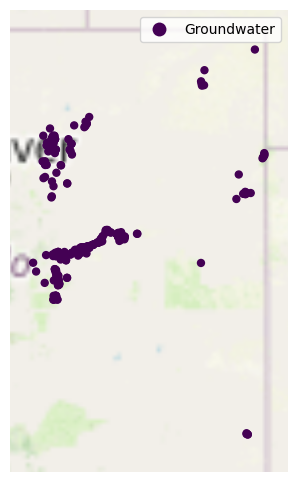

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
1512,COwr_S105045,COre_ROco11,COwr_WSwadeID34,WaDE Blank,Spotted from section lines,Adams,4326,,,,,39.88500,-104.51019,,,POD,Anderson Well 6528,105045,,Well,CO,


#### Regulatory Area Data #2

In [13]:
# dfru2 = dfru.copy()
# etc etc

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [14]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

125927


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,COwr_S1000503,,COwr_WSwadeID432,WaDE Blank,GPS,El Paso,4326,,,,,39.107329,-104.926624,,,POD,Monument Ditch,1000503,,Ditch,CO,,COwr_WSwadeID432,Surface Water


# Inspect Output Data & Export

In [15]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125927 entries, 0 to 125926
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                125927 non-null  object
 1   RegulatoryOverlayUUIDs  125927 non-null  object
 2   WaterSourceUUIDs        125927 non-null  object
 3   CoordinateAccuracy      125927 non-null  object
 4   CoordinateMethodCV      125927 non-null  object
 5   County                  125927 non-null  object
 6   EPSGCodeCV              125927 non-null  object
 7   Geometry                125927 non-null  object
 8   GNISCodeCV              125927 non-null  object
 9   HUC12                   125927 non-null  object
 10  HUC8                    125927 non-null  object
 11  Latitude                125927 non-null  object
 12  Longitude               125927 non-null  object
 13  NHDNetworkStatusCV      125927 non-null  object
 14  NHDProductCV            125927 non-n

In [16]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,COwr_S1000503,,COwr_WSwadeID432,WaDE Blank,GPS,El Paso,4326,,,,,39.107329,-104.926624,,,POD,Monument Ditch,1000503,,Ditch,CO,,COwr_WSwadeID432,Surface Water
1,COwr_S1000504,,COwr_WSwadeID432,WaDE Blank,GPS,El Paso,4326,,,,,39.062509,-104.867375,,,POD,Monument Ditch No 2,1000504,,Ditch,CO,,COwr_WSwadeID432,Surface Water
2,COwr_S1000506,,COwr_WSwadeID432,WaDE Blank,GPS,El Paso,4326,,,,,38.902562,-104.823411,,,POD,Monument Creek Pipeline,1000506,,Pipeline,CO,,COwr_WSwadeID432,Surface Water
3,COwr_S1000520,,COwr_WSwadeID413,WaDE Blank,GPS,El Paso,4326,,,,,38.895625,-104.891395,,,POD,Glen Eyrie Pipeline,1000520,,Pipeline,CO,,COwr_WSwadeID413,Surface Water
4,COwr_S1000522,,COwr_WSwadeID413,WaDE Blank,Digitized,El Paso,4326,,,,,38.936872,-104.945181,,,POD,Camp Creek Pipeline,1000522,,Pipeline,CO,,COwr_WSwadeID413,Surface Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125922,COwr_S906317,,COwr_WSwadeID8,WaDE Blank,Spotted from section lines,Jefferson,4326,,,,,39.629913,-105.271512,,,POD,Neal Well 1,906317,,Well,CO,,COwr_WSwadeID8,Groundwater
125923,COwr_S906320,,COwr_WSwadeID7,WaDE Blank,Spotted from section lines,Jefferson,4326,,,,,39.69343,-105.299624,,,POD,Riggio Well 1 166254,906320,,Well,CO,,COwr_WSwadeID7,Groundwater
125924,COwr_S906322,,COwr_WSwadeID7,WaDE Blank,Spotted from section lines,Jefferson,4326,,,,,39.597496,-105.348338,,,POD,Crockett Well 1,906322,,Well,CO,,COwr_WSwadeID7,Groundwater
125925,COwr_S906323,,COwr_WSwadeID7,WaDE Blank,Spotted from section lines,Jefferson,4326,,,,,39.592947,-105.332371,,,POD,Faydenko Well 1,906323,,Well,CO,,COwr_WSwadeID7,Groundwater


In [17]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder